# Identify user's affiliation with IBM
Author: Daheng Wang  
Last modified: 2017-05-04

# Roadmap
1. Use multiprocessing to tag all updated tweets whether it includes keyword 'ibm' in its 'text' field
2. Identify affiliation based on the proportion of tweets with keyword 'ibm' in its 'text' field

# Steps

## Initialization

In [2]:
# Data analysis modules: pandas, matplotlib, numpy, and etc.
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # render double resolution plot output for Retina screens 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Standard modules, MongoDB modules
import os, sys, json, datetime, pickle, multiprocessing, logging
from pprint import pprint

import pymongo
from pymongo import IndexModel, ASCENDING, DESCENDING

# Custom tool modules
import mongodb  # module for setting up connection with (local) MongoDB database
import multiprocessing_workers  # module for splitting workloads between processes
import utilities  # module for various custom utility functions
from config import * # import all global configuration variables

## Use multiprocessing to tag tweets with keyword 'ibm'

_Step 1_ For each tweet in updated collection, test whether the keyword 'ibm' appears in its 'text' field. To speedup the process, use multiprocessing. Output results into intermediate files.

In [2]:
inter_files = []
if 0 == 1:
    procedure_name = 'tag_{}_text'.format(UPDATED_COL)
    keyword = 'ibm'
    
    multiprocessing.log_to_stderr(logging.DEBUG)
    process_n = multiprocessing.cpu_count() - 1 # set processes number to CPU numbers minus 1
    suffix = 'json'
    inter_files = utilities.gen_inter_filenames_list(procedure_name, process_n, suffix)
    
    jobs = []
    for batch_i in range(process_n):
        p = multiprocessing.Process(target=multiprocessing_workers.worker_tag_keyword_in_tweet,
                                    args=(DB_NAME, UPDATED_COL, batch_i, process_n, inter_files[batch_i], keyword),
                                    name='Process-{}/{}'.format(batch_i, process_n))
        jobs.append(p)
    
    for job in jobs:
        job.start()
        
    for job in jobs:
        job.join()

[INFO/Process-0/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek.c2 connected successfully!
Process0/11 handling documents 0 to 458506...


[INFO/Process-1/11] child process calling self.run()
[INFO/Process-3/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek.c2 connected successfully!


[INFO/Process-2/11] child process calling self.run()
[INFO/Process-4/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek.c2 connected successfully!
MongoDB on localhost:27017/tweets_ek.c2 connected successfully!
MongoDB on localhost:27017/tweets_ek.c2 connected successfully!


[INFO/Process-5/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek.c2 connected successfully!


[INFO/Process-7/11] child process calling self.run()
[INFO/Process-6/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek.c2 connected successfully!
MongoDB on localhost:27017/tweets_ek.c2 connected successfully!


[INFO/Process-8/11] child process calling self.run()
[INFO/Process-9/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek.c2 connected successfully!


[INFO/Process-10/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek.c2 connected successfully!
MongoDB on localhost:27017/tweets_ek.c2 connected successfully!
Process1/11 handling documents 458507 to 917013...
Process2/11 handling documents 917014 to 1375520...
Process3/11 handling documents 1375521 to 1834027...
Process4/11 handling documents 1834028 to 2292534...
Process5/11 handling documents 2292535 to 2751041...
Process6/11 handling documents 2751042 to 3209548...
Process7/11 handling documents 3209549 to 3668055...
Process8/11 handling documents 3668056 to 4126562...
Process9/11 handling documents 4126563 to 4585069...
Process10/11 handling documents 4585070 to 5043587...


[INFO/Process-0/11] process shutting down
[DEBUG/Process-0/11] running all "atexit" finalizers with priority >= 0
[DEBUG/Process-0/11] running the remaining "atexit" finalizers
[INFO/Process-0/11] process exiting with exitcode 0
[INFO/Process-1/11] process shutting down
[DEBUG/Process-1/11] running all "atexit" finalizers with priority >= 0
[DEBUG/Process-1/11] running the remaining "atexit" finalizers
[INFO/Process-1/11] process exiting with exitcode 0
[INFO/Process-2/11] process shutting down
[DEBUG/Process-2/11] running all "atexit" finalizers with priority >= 0
[DEBUG/Process-2/11] running the remaining "atexit" finalizers
[INFO/Process-2/11] process exiting with exitcode 0
[INFO/Process-3/11] process shutting down
[DEBUG/Process-3/11] running all "atexit" finalizers with priority >= 0
[DEBUG/Process-3/11] running the remaining "atexit" finalizers
[INFO/Process-3/11] process exiting with exitcode 0
[INFO/Process-4/11] process shutting down
[DEBUG/Process-4/11] running all "atexit" 

_Step 2_ Import all tagging results, which are stored in intermediate files, into a new collection in MongoDB database.

In [2]:
"""
This section generates a new collection for tagging results of whether keyword 'ibm' appears in 'text' field of tweets.
Register IBM_TAG_COL = 'c2_ibm_tag' in config if first time.
"""
if 0 == 1:
    ibm_tag_col = mongodb.initialize(db_name=DB_NAME, collection_name=IBM_TAG_COL)
    for inter_file in inter_files:
        print('Reading {}...'.format(inter_file), end=' ')
        lines = open(inter_file).readlines()
        parsed_jsons = [json.loads(line) for line in lines]
        print('Importing into {}.{}...'.format(DB_NAME, IBM_TAG_COL))
        ibm_tag_col.insert_many(parsed_jsons)
    print('Done')

MongoDB on localhost:27017/tweets_ek.c2_ibm_tag connected successfully!


_Step 3_ Build compound index 'user_id'-'id' on new colleciton

In [3]:
if 0 == 1:
    ibm_tag_col = mongodb.initialize(db_name=DB_NAME, collection_name=IBM_TAG_COL)
    index_lst = [('user_id', pymongo.ASCENDING),
                 ('id', pymongo.ASCENDING)]
    print('Building compond index {}...'.format(index_lst))
    ibm_tag_col.create_index(keys=index_lst)
    print('Done')

Check indexes on new collection

In [4]:
if 0 == 1:
    pprint(ibm_tag_index.index_information())

_Step 4_ Check basic statistic of the new collection

Check how many tweets in total?

In [2]:
ibm_tag_col = mongodb.initialize(db_name=DB_NAME, collection_name=IBM_TAG_COL)

MongoDB on localhost:27017/tweets_ek.c2_ibm_tag connected successfully!


In [3]:
tweet_num = ibm_tag_col.count()
print('{} tweets in new collection'.format(tweet_num))

5043587 tweets in new collection


Check how many unique users in total?

In [4]:
user_num = len(ibm_tag_col.distinct(key='user_id'))
print('{} unique users in new collection'.format(user_num))

844675 unique users in new collection


Average number of tweets of each user?

In [5]:
avg_tweet_num = tweet_num / user_num
pprint('On average, {:4.2f} tweets are authored by a single user'.format(avg_tweet_num))

'On average, 5.97 tweets are authored by a single user'


Check how many tweets are tagged as having 'ibm' keyword in 'text' field 

In [6]:
ibm_tweet_num = ibm_tag_col.count(filter={'text_ibm': {'$eq': True}})
print('{} ({:.2%} out of total) tweets are tagged as with "ibm" keyword'.format(ibm_tweet_num, ibm_tweet_num / tweet_num))

212941 (4.22% out of total) tweets are tagged as with "ibm" keyword


## Aggreate 'tweets_count' and 'ibm_tweets_count' on each user and pickle into local file

_Step 1_ Pickle necessary information into list of dictionaries.  
```{'user_id': user_id, 'tweets_count': tweets_count, 'ibm_tweets_count': ibm_tweets_count}```

In [3]:
user_tweets_and_ibm_tweets_count_pkl = os.path.join(TMP_DIR, 'user_tweets_and_ibm_tweets_count.lst.pkl')

In [4]:
if not os.path.exists(user_tweets_and_ibm_tweets_count_pkl):
    print("Building pickle from database...")
    data_lst = []
    
    group_dict = {'$group': {'_id': '$user_id',                            
                             'tweets_count': {'$sum': 1},
                             'ibm_tweets_count': {'$sum': {'$cond': ['$text_ibm', 1, 0]}}}}
    project_dic = {'$project': {'_id': 0,
                                'user_id': '$_id',
                                'tweets_count': 1,
                                'ibm_tweets_count': 1}}
    
    ppl_lst = [group_dict, project_dic]
    print('Aggreating on collection "{}"'.format(IBM_TAG_COL))
    ibm_tag_col = mongodb.initialize(db_name=DB_NAME, collection_name=IBM_TAG_COL)
    cursor = ibm_tag_col.aggregate(pipeline=ppl_lst,
                                   allowDiskUse=True) # Exceeded memory limit for $group, but didn't allow external sort. Pass allowDiskUse:true to opt in.
    
    for doc in cursor:
        data_lst.append(doc)
    
    with open(user_tweets_and_ibm_tweets_count_pkl, 'wb') as f:
        pickle.dump(data_lst, f)
    print('Done')
else:
    print('Pickled data found')

Pickled data found


## Plot the proportion against number of tweets on different scales

_Step 1_ Load information from local pickle file.

In [5]:
if 1 == 1:
    data_lst = []
    with open(user_tweets_and_ibm_tweets_count_pkl, 'rb') as f:
        data_lst = pickle.load(f)
        
    df = pd.DataFrame(data=data_lst,
                      columns=['user_id', 'tweets_count', 'ibm_tweets_count'], # explicitly pass in names of columns
                      dtype=int)

    # compute the proportion of 'ibm tweets' agst. all tweets for each user
    df['ibm_tweets_prop'] = df['ibm_tweets_count'] / df['tweets_count']

In [10]:
pprint(df.describe())

            user_id   tweets_count  ibm_tweets_count  ibm_tweets_prop
count  8.446750e+05  844675.000000     844675.000000    844675.000000
mean   1.543554e+17       5.971039          0.252098         0.047543
std    3.152972e+17     143.575276          5.022478         0.192320
min    1.200000e+01       1.000000          0.000000         0.000000
25%    1.600196e+08       1.000000          0.000000         0.000000
50%    9.991254e+08       1.000000          0.000000         0.000000
75%    3.291247e+09       2.000000          0.000000         0.000000
max    8.512290e+17   61375.000000       1830.000000         1.000000


_Step 2_ Compute the proportion of ibm-tweets for each user and plot.

In [8]:
ibm_tweets_prop_fig = os.path.join(FIG_DIR, 'ibm_tweets_prop.png')

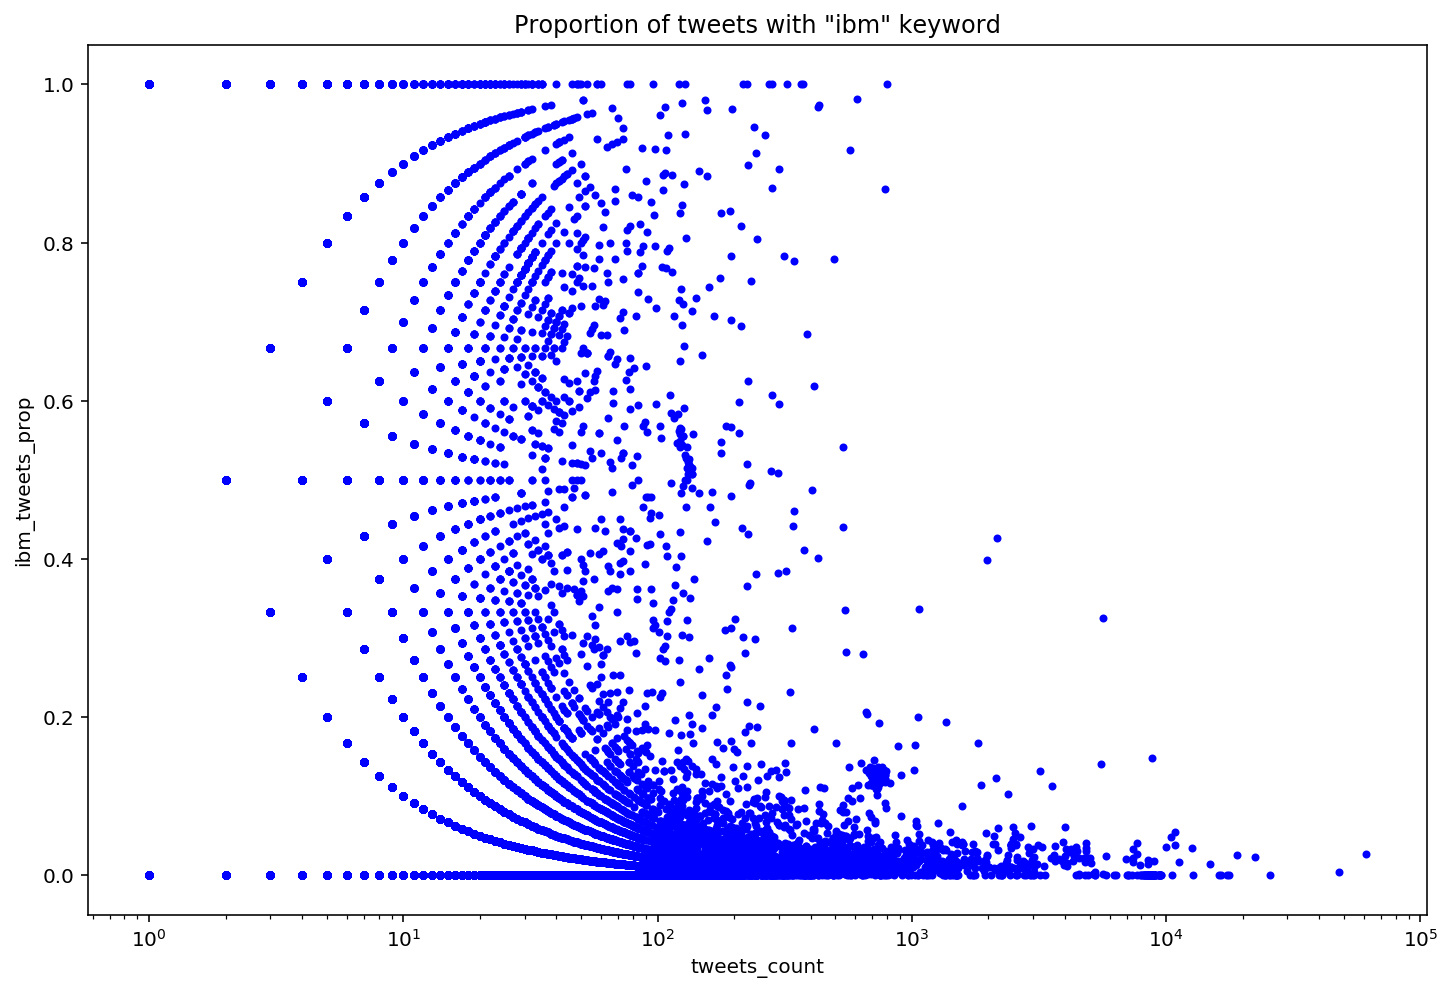

In [9]:
if 1 == 1:
    X = df['tweets_count']
    Y = df['ibm_tweets_prop']
    
    plt.figure(figsize=(12, 8))
    plt.title('Proportion of tweets with "ibm" keyword')
    plt.xlabel('tweets_count')
    plt.ylabel('ibm_tweets_prop')
    
#     plt.axvline(x=6, color='g')
#     plt.axhline(y=0.0475, color='g')
#     plt.axhline(y=0.2, color='g')
    
    plt.xscale('log')
#     plt.yscale('log')
    plt.plot(X, Y ,'b.')
    plt.savefig(ibm_tweets_prop_fig)

## Test identifying affiliation with different combinations of (tweets_count, ibm_tweets_prop) parameters

We are looking for users:
1. with _high_ 'ibm_tweets_prop' value, which means they frequently mention keyword 'ibm' in their tweets.
2. with _high_ 'tweets_count' value. So that the 'ibm_tweets_prop' value would be more meaningful.

### Check difference between IBM/non-IBM users identified by method_1

_Step 1_ Read in user ids list for IBM/non-IBM users identified by method_1 from local pickle file. Pass into df.

In [13]:
if 1 == 1:
    m1_ibm_user_ids_lst = []
    m1_nonibm_user_ids_lst = []

    if not m1_ibm_user_ids_lst:
        with open(M1_IBM_USER_IDS_PKL, 'rb') as f:
            m1_ibm_user_ids_lst = pickle.load(f)
        #print('Read local pickle: "{}"'.format(pkl))

    if not m1_nonibm_user_ids_lst:
        with open(M1_NONIBM_USER_IDS_PKL, 'rb') as f:
            m1_nonibm_user_ids_lst = pickle.load(f)
        #print('Read local pickle: "{}"'.format(pkl))

    m1_ibm_user_cond = df['user_id'].isin(m1_ibm_user_ids_lst)
    m1_nonibm_user_cond = df['user_id'].isin(m1_nonibm_user_ids_lst)
    
    df_m1_ibm_user = df[m1_ibm_user_cond]
    df_m1_nonibm_user = df[m1_nonibm_user_cond]

_Step 3_ Check basic statistics

In [14]:
df_m1_ibm_user.describe()

,user_id,tweets_count,ibm_tweets_count,ibm_tweets_prop
count,6.736000e+03,6736.000000,6736.000000,6736.000000
mean,5.350414e+16,11.606888,6.666271,0.646110
std,1.970980e+17,77.351546,31.898679,0.383342
min,1.142600e+04,1.000000,0.000000,0.000000
25%,6.541229e+07,1.000000,1.000000,0.333333
50%,3.732915e+08,3.000000,2.000000,0.777778
75%,2.318449e+09,8.000000,5.000000,1.000000
max,8.501870e+17,5631.000000,1830.000000,1.000000


In [15]:
df_m1_nonibm_user.describe()

,user_id,tweets_count,ibm_tweets_count,ibm_tweets_prop
count,8.379390e+05,837939.000000,837939.000000,837939.000000
mean,1.551662e+17,5.925733,0.200536,0.042732
std,3.159380e+17,143.983408,4.112934,0.182208
min,1.200000e+01,1.000000,0.000000,0.000000
25%,1.614600e+08,1.000000,0.000000,0.000000
50%,1.012522e+09,1.000000,0.000000,0.000000
75%,3.297588e+09,2.000000,0.000000,0.000000
max,8.512290e+17,61375.000000,1617.000000,1.000000


**Observations**  
We can see that, for method_1:
1. IBM users have higher mean 'ibm_tweets_count' and  than non-IBM users (6.67 > 0.20). This suggests that IBM users are more likely to include keyword 'IBM' in their tweets, which follows intuition.
2. Correspondingly, IBM users have higher mean 'ibm_tweets_prop' and  than non-IBM users (64.6% > 4.3%). This can be used to help us in method_2 below.
3. The differences of 'tweets_count' between IBM users and non-IBM users are not significant.

### Test on different 'ibm_tweets_prop' values

_Step 1_ We use relatively loose constraints. We treat all users have above average values on 'ibm_tweets_prop' as IBM-users.

In [16]:
if 1 == 1:
    # selection condition for 'ibm_tweets_prop' above average
    mean_ibm_tweets_prop = 0.0475
    cond1 = df['ibm_tweets_prop'] > mean_ibm_tweets_prop
    df_1 = df[cond1]

In [17]:
pprint(df_1.describe())

            user_id  tweets_count  ibm_tweets_count  ibm_tweets_prop
count  6.624700e+04  66247.000000      66247.000000     66247.000000
mean   1.634946e+17     10.899543          2.753604         0.603940
std    3.238458e+17     94.918202         15.508457         0.368242
min    8.740000e+02      1.000000          1.000000         0.047619
25%    1.330050e+08      1.000000          1.000000         0.250000
50%    1.060300e+09      2.000000          1.000000         0.500000
75%    3.338035e+09      7.000000          2.000000         1.000000
max    8.511072e+17  10865.000000       1830.000000         1.000000


In [18]:
user_num = 844675
row_n = df_1.shape[0]
print('{} ({:.2%}) users identified as IBM-users by this method'.format(row_n, row_n / user_num))

66247 (7.84%) users identified as IBM-users by this method


Check the overlap with method_1

In [19]:
m1_ibm_user_ids_set = set(m1_ibm_user_ids_lst)
m2_ibm_user_ids_set = set(df_1['user_id'])

common_ibm_users_num = len(m1_ibm_user_ids_set.intersection(m2_ibm_user_ids_set))
print('{} users identified as IBM-user by both methods'.format(common_ibm_users_num))
print('This accounts for ({:.2%}) of users identified by method_1'.format(common_ibm_users_num / len(m1_ibm_user_ids_set)))

5483 users identified as IBM-user by both methods
This accounts for (81.40%) of users identified by method_1


_Step 2_ We test on various 'ibm_tweets_prop' values

Build df.

In [20]:
if 1 == 1:
    ibm_tweets_prop_lst = np.arange(0.005, 0.995, 0.0025)
    
    cmm_ibm_user_pct_lst = []
    total_users_pct_lst = []
    
    for ibm_tweets_prop in ibm_tweets_prop_lst:
        user_num = 844675
        
        select_cond = df['ibm_tweets_prop'] > ibm_tweets_prop
        df_tmp = df[select_cond]
        
        tmp_user_ids_set = set(df_tmp['user_id'])
        cmm_ibm_user_pct = len(m1_ibm_user_ids_set.intersection(tmp_user_ids_set)) / len(m1_ibm_user_ids_set)
        cmm_ibm_user_pct_lst.append(cmm_ibm_user_pct)
        
        row_n = df_tmp.shape[0] # number of users identified
        total_users_pct = row_n / user_num
        total_users_pct_lst.append(total_users_pct)

Plot

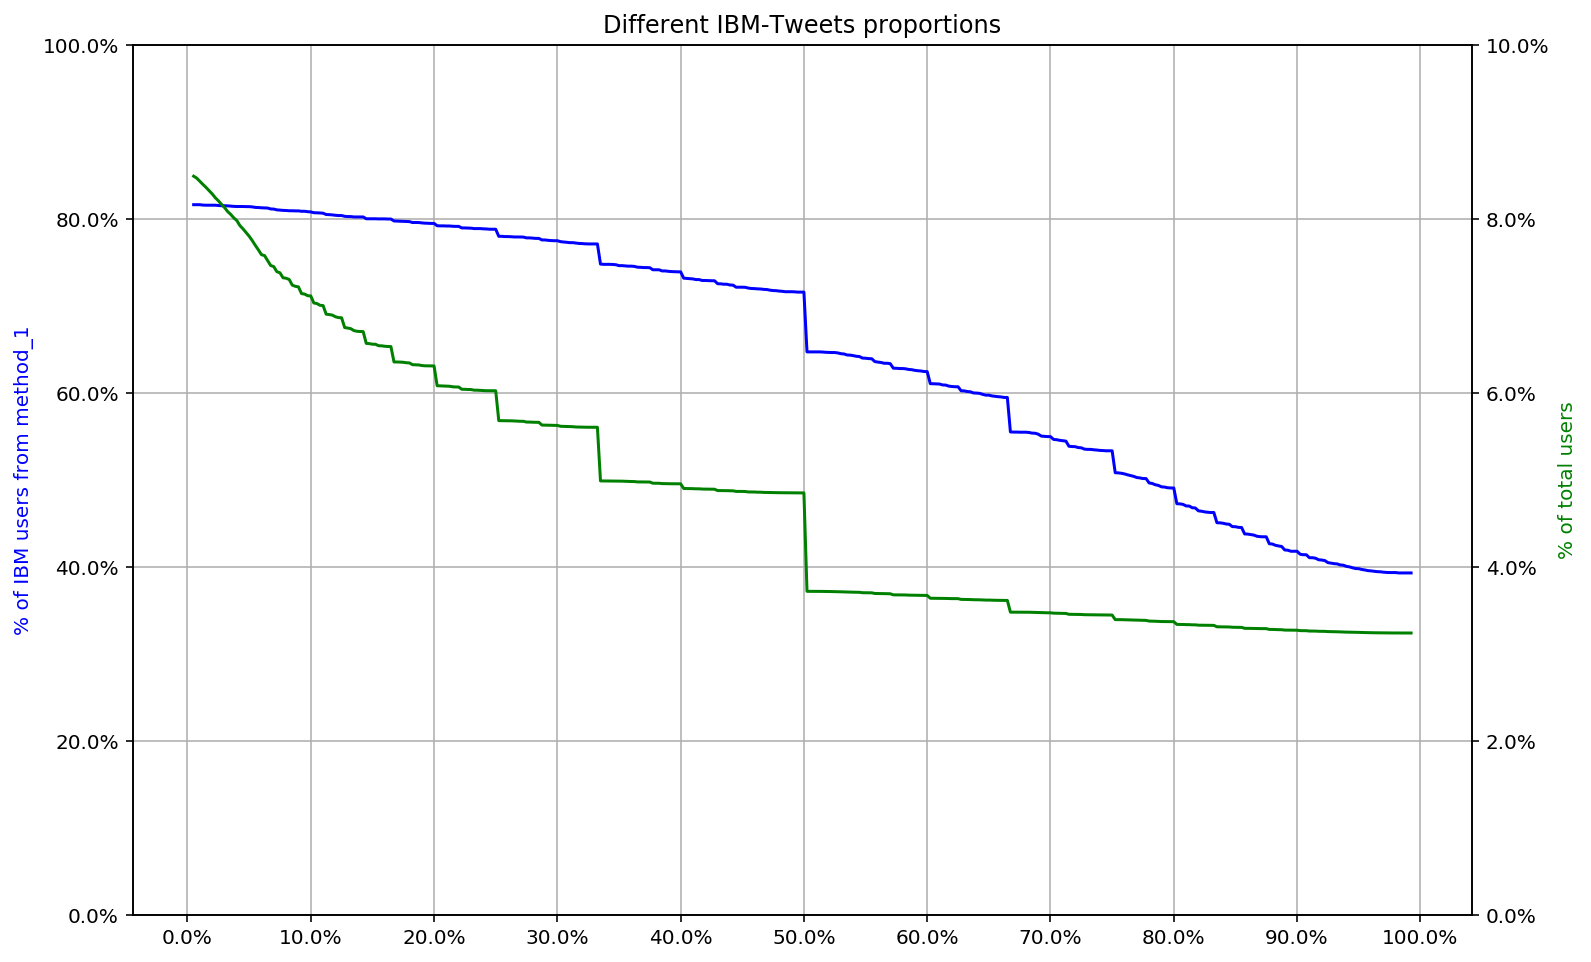

In [21]:
if 1 == 1:
    fig, ax1 = plt.subplots()
    fig.set_size_inches((12,8))
    ax1.set_title('Different IBM-Tweets proportions')
    
    X = ibm_tweets_prop_lst
    Y1 = cmm_ibm_user_pct_lst
    ax1.plot(X, Y1, 'b-')
    ax1.set_ylabel("% of IBM users from method_1", color='blue')
    ax1.set_ylim(0, 1)
    ax1.set_xticks(np.arange(0, 1.1, 0.1))
    X_vals = ax1.get_xticks()
    ax1.set_xticklabels(['{:.1%}'.format(X_val) for X_val in X_vals])
    ax1.grid()
    
    Y1_vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:.1%}'.format(Y1_val) for Y1_val in Y1_vals])
    

    ax2 = ax1.twinx()
    Y2 = total_users_pct_lst
    ax2.plot(X, Y2, 'g-')
    ax2.set_ylabel("% of total users", color='g')
    ax2.set_ylim(0, 0.1)
    Y2_vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:.1%}'.format(Y2_val) for Y2_val in Y2_vals])

### With minimum 'tweets_count', test on different 'ibm_tweets_prop' values

Only consider users with above average 'tweets_count'.

In [22]:
if 1 == 1:
    # selection condition for 'ibm_tweets_prop' above average
    mean_ibm_tweets_prop = 0.0475
    cond1 = df['ibm_tweets_prop'] > mean_ibm_tweets_prop
    
    # selection condition for 'tweets_count' above average
    mean_tweets_count = 5.971039
    cond2 = df['tweets_count'] > mean_tweets_count
    
    df_2 = df[cond1 & cond2]

In [23]:
pprint(df_2.describe())

            user_id  tweets_count  ibm_tweets_count  ibm_tweets_prop
count  1.914400e+04  19144.000000      19144.000000     19144.000000
mean   1.100759e+17     32.871814          6.600867         0.245139
std    2.722811e+17    174.629299         28.472668         0.253806
min    8.740000e+02      6.000000          1.000000         0.047619
25%    1.048123e+08      8.000000          1.000000         0.083333
50%    7.746492e+08     13.000000          2.000000         0.136364
75%    3.046136e+09     21.000000          5.000000         0.285714
max    8.508085e+17  10865.000000       1830.000000         1.000000


In [24]:
if 1 == 1:
    ibm_tweets_prop_lst = np.arange(0.005, 0.995, 0.0025)
    
    cmm_ibm_user_pct_lst = []
    total_users_pct_lst = []
    
    for ibm_tweets_prop in ibm_tweets_prop_lst:
        user_num = 844675
        #min_tweets_count = 5.971039
        min_tweets_count = 1
        
        # selection condition for 'ibm_tweets_prop' above average
        select_cond_1 = df['ibm_tweets_prop'] > ibm_tweets_prop
        # selection condition for 'tweets_count' above average
        select_cond_2 = df['tweets_count'] > min_tweets_count
        df_tmp_2 = df[select_cond_1 & select_cond_2]
        
        tmp_2_user_ids_set = set(df_tmp_2['user_id'])
        cmm_ibm_user_pct = len(m1_ibm_user_ids_set.intersection(tmp_2_user_ids_set)) / len(m1_ibm_user_ids_set)
        cmm_ibm_user_pct_lst.append(cmm_ibm_user_pct)
        
        row_n = df_tmp_2.shape[0] # number of users identified
        total_users_pct = row_n / user_num
        total_users_pct_lst.append(total_users_pct)

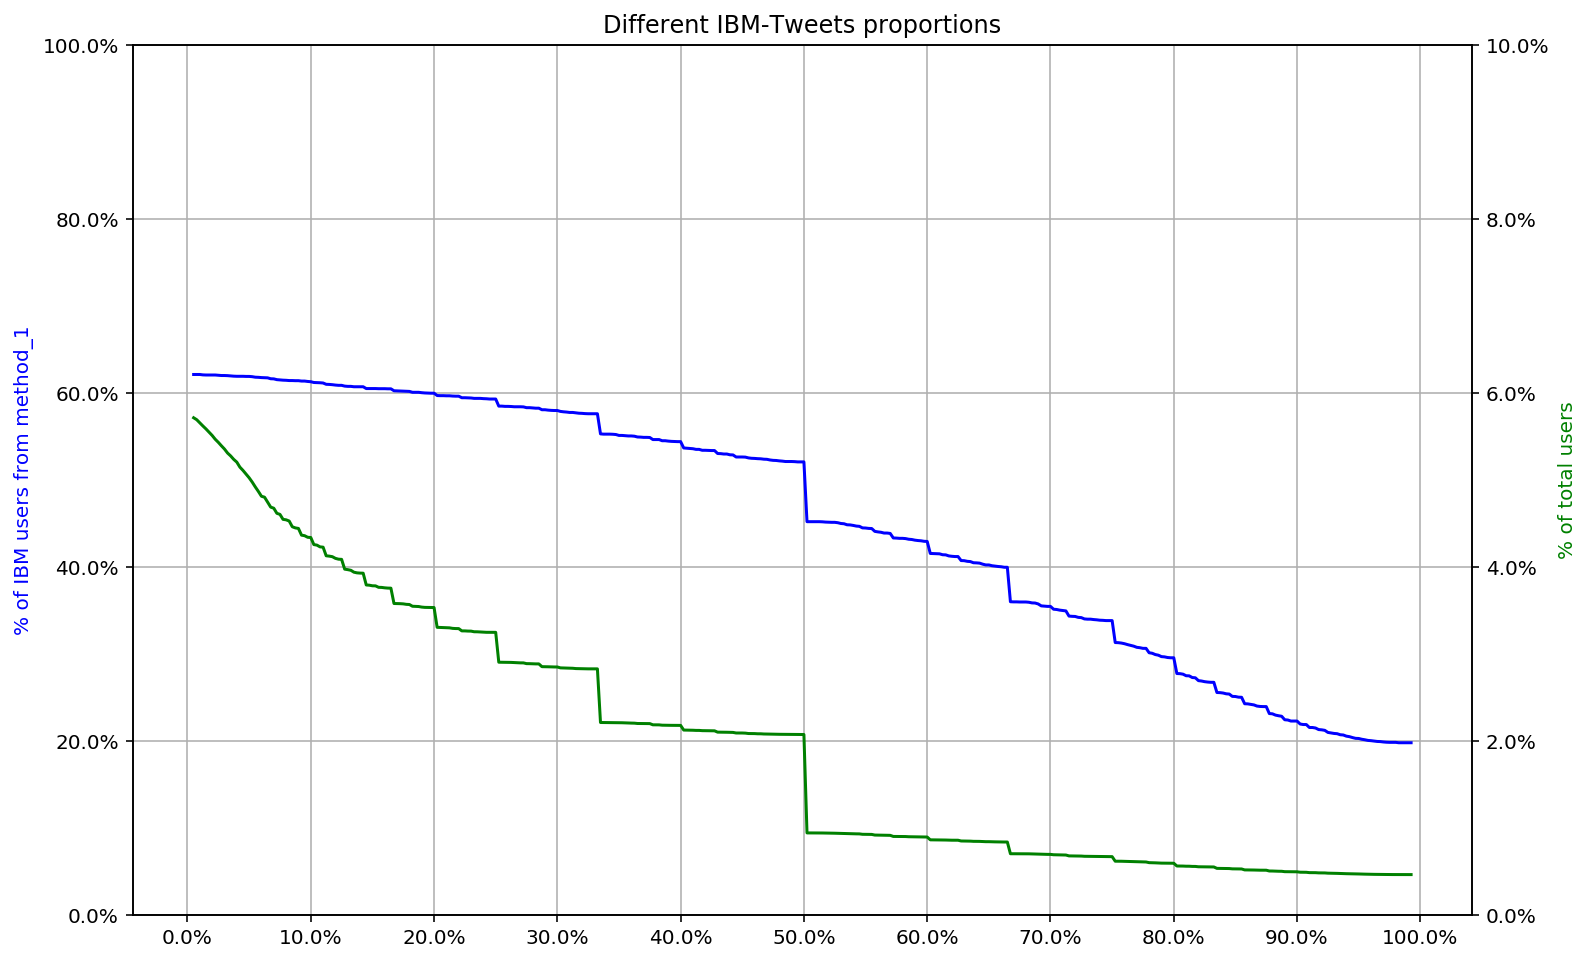

In [25]:
if 1 == 1:
    fig, ax1 = plt.subplots()
    fig.set_size_inches((12,8))
    ax1.set_title('Different IBM-Tweets proportions')
    
    X = ibm_tweets_prop_lst
    Y1 = cmm_ibm_user_pct_lst
    ax1.plot(X, Y1, 'b-')
    ax1.set_ylabel("% of IBM users from method_1", color='blue')
    ax1.set_ylim(0, 1)
    ax1.set_xticks(np.arange(0, 1.1, 0.1))
    X_vals = ax1.get_xticks()
    ax1.set_xticklabels(['{:.1%}'.format(X_val) for X_val in X_vals])
    ax1.grid()
    
    Y1_vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:.1%}'.format(Y1_val) for Y1_val in Y1_vals])
    

    ax2 = ax1.twinx()
    Y2 = total_users_pct_lst
    ax2.plot(X, Y2, 'g-')
    ax2.set_ylabel("% of total users", color='g')
    ax2.set_ylim(0, 0.1)
    Y2_vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:.1%}'.format(Y2_val) for Y2_val in Y2_vals])
    

## Write out to local pickle file

**Observations**  
We can see that, as we increase 'ibm_tweets_prop', we have less users identified as IBM-users. And, in the meantime, we have fewer IBM-users identifed by method_1 included in our selection.  
When we increase 'ibm_tweets_prop' from 0.25% up to 20%, the % of IBM users from method_1 slightly drops, and the % of total users decreases from 8% to 6%.  
Keep increasing 'ibm_tweets_prop' up to 60%, both % of IBM users from method_1 and % of total users decreases have a few big drops.
After that, % of IBM users from method_1 keeps dropping while % of total users remain relatively stable.
Our objective is to include as many users we already identified by using method_1 as possible, while keep the number of user identified as small as possible.  
So, we chose 'ibm_tweets_prop' = 10% conservatively to include more people in the set.

In [26]:
"""
This section generates two new global pickle files: list of 'ibm users' and list of 'non-ibm users', for method_2.
Register M2_IBM_USER_IDS_PKL = os.path.join(DATA_DIR, 'm2_ibm_user_ids.lst.pkl')
and M2_NONIBM_USER_IDS_PKL = os.path.join(DATA_DIR, 'm2_nonibm_user_ids.lst.pkl')
in config if first time.
"""
target_ibm_tweets_prop = 0.1
if 1 == 1:
    target_cond = df['ibm_tweets_prop'] > target_ibm_tweets_prop
    df_target = df[target_cond]
    m2_ibm_user_ids_lst = list(df_target['user_id'])
    
    pkl = M2_IBM_USER_IDS_PKL
    print('{} "ibm user" ids get'.format(len(m2_ibm_user_ids_lst)))
    print('Dumping to local pickle "{}"'.format(pkl))
    with open(pkl, 'wb') as f:
        pickle.dump(m2_ibm_user_ids_lst, f)
    print('Done')

if 1 == 1:
    df_nontarget = df[df['ibm_tweets_prop'] <= target_ibm_tweets_prop]
    m2_nonibm_user_ids_lst = list(df_nontarget['user_id'])
    
    pkl = M2_NONIBM_USER_IDS_PKL
    print('{} "nonibm user" ids get'.format(len(m2_nonibm_user_ids_lst)))
    print('Dumping to local pickle "{}"'.format(pkl))
    with open(pkl, 'wb') as f:
        pickle.dump(m2_nonibm_user_ids_lst, f)
    print('Done')

59407 "ibm user" ids get
Dumping to local pickle "./data/m2_ibm_user_ids.lst.pkl"
Done
785268 "nonibm user" ids get
Dumping to local pickle "./data/m2_nonibm_user_ids.lst.pkl"
Done


## Check whether accounts @Natasha_D_G and @jameskobielus are included.

While by using method_1, we can identify all users have keyword 'ibm' in their description field as affiliated with IBM, method_1 is limited that not all users would explicitly express their affiliation with IBM in their description field. So, the users identified by method_1 should be a subset of actual users affiliated with IBM. In other words, there are more users affiliated with IBM.
The idea we use here is that, if a person frequently mention keyword 'ibm' in tweets, he or she is highly likely affiliated with IBM. We use the proportion of tweets with keyword 'ibm' to identify these users. 

In [27]:
if 1 == 1:
    screen_name_1 = 'Natasha_D_G'
    screen_name_2 = 'jameskobielus'
    
    id_1 = 39413322
    id_2 = 14072398
    
    m2_ibm_user_ids_lst = []
    with open(M2_IBM_USER_IDS_PKL, 'rb') as f:
        m2_ibm_user_ids_lst = pickle.load(f)
    
    print('User {} exists in IBM-user set? {}'.format(screen_name_1, id_1 in set(m2_ibm_user_ids_lst)))
    print('User {} exists in IBM-user set? {}'.format(screen_name_2, id_2 in set(m2_ibm_user_ids_lst)))

User Natasha_D_G exists in IBM-user set? True
User jameskobielus exists in IBM-user set? True


~~Since @jameskobielus (James Kobielus) is not identified as IBM-user by our method_2, we check the tweets we captured for him.~~

How many tweets we have in our database authored by @jameskobielus?

In [28]:
updated_col = mongodb.initialize(db_name=DB_NAME, collection_name=UPDATED_COL)
jameskobielus_tweets_num = updated_col.count(filter={'user.id': id_2})
print('{} tweets we have for user {}'.format(jameskobielus_tweets_num, screen_name_2))

MongoDB on localhost:27017/tweets_ek.c2 connected successfully!
58 tweets we have for user jameskobielus


Check the content of these tweets

In [29]:
cursor = updated_col.find(filter={'user.id': id_2}, projection={'_id':0, 'id': 1, 'text': 1})
count = 0
for doc in cursor:
    count += 1
    tweet_id = doc['id']
    tweet_text = doc['text']
    print('{}. ({})'.format(count, tweet_id))
    print(tweet_text)

1. (838756446363865089)
"Making sense of machine learning" (https://t.co/BGcmgG5MX8) JK--Eric Knorr parses definitions correctly: AI v. ML v. neural nets v. etc
2. (838759087387062272)
"120 Machine Learning business ideas" (https://t.co/NagS8tJOdc) JK--Substitute "big data analytics" for "ML," &amp; this is so 4 years ago
3. (838759808522153984)
"How to Generate Art - Intro to Deep Learning" (https://t.co/qPcVmEZV0q) JK--Computational artistry era awaits its Da Vinci.
4. (838763534418731008)
#Watson https://t.co/uQItFIwqBm https://t.co/2iV7XVrXGr
5. (838763654501707776)
#SecurityIntelligence #Watson https://t.co/PPjWIQfiAT https://t.co/O2PSZO82GB
6. (839160498595692544)
"Attention and Augmented Recurrent Neural Networks" (https://t.co/Z7jiq0CSVq) JK--Great dissection of key advances in this core DL approach
7. (839161477890191365)
"Davos 2016 - The State of Artificial Intelligence" (https://t.co/QfKpivHZT7) JK--When geekly topics consume world mover/shakers, watch out!
8. (839163344284

After manully checking all his tweets, 9 tweets were found including 'ibm' keyword.

# Notes